# Understanding the HES data set

In this post, I'll show some characteristics of Household Electricity Survey [HES](https://www.gov.uk/government/publications/household-electricity-survey--2) data set using [nilmtk](http://nilmtk.github.io/). It contains data from 250 homes in the UK. [Oliver Parson](http://oliverparson.co.uk/) and [Jack Kelly](http://jack-kelly.com/) have written importers for the data set. I'll use the [nilmtk importer](https://github.com/nilmtk/nilmtk/tree/master/nilmtk/dataset_converters/hes) written by Oliver in this analysis. This notebook should also be a good starting point for similar analysis across other data sets. This post is inspired by some of Oliver's post(like [1](http://blog.oliverparson.co.uk/2016/01/refit-analysis-using-nilmtk-converter.html), [2](http://blog.oliverparson.co.uk/2015/09/dataport-data-released-in-nilmtk-format.html)) and the awesome functions that Jack had written for comparing different NILM data sets.

### Code preliminaries

In [1]:
from nilmtk import *
import nilmtk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 25 days


In [2]:
ds= DataSet("/data/hes/hes_3.h5")

In [3]:
len(ds.buildings)

250

There are 250 buildings in the dataset

Let us look at the instrumented appliances in the first building.

In [4]:
elec = ds.buildings[1].elec

In [5]:
elec.meters[:5]

[ElecMeter(instance=1, building=1, dataset='HES', appliances=[Appliance(type='freezer', instance=1)]),
 ElecMeter(instance=2, building=1, dataset='HES', appliances=[Appliance(type='freezer', instance=2)]),
 ElecMeter(instance=3, building=1, dataset='HES', appliances=[Appliance(type='fridge', instance=1)]),
 ElecMeter(instance=4, building=1, dataset='HES', appliances=[Appliance(type='fridge freezer', instance=1)]),
 ElecMeter(instance=5, building=1, dataset='HES', appliances=[Appliance(type='fridge', instance=2)])]

In [6]:
len(elec.meters)

93

That's a whooping 93 meters in this home!

### Number of instrumented loads per home

Let us see the number of meters instrumented across different homes.

In [7]:
num_meters = {}
for building_num, building in ds.buildings.iteritems():
    num_meters[building_num] = len(building.elec.meters)

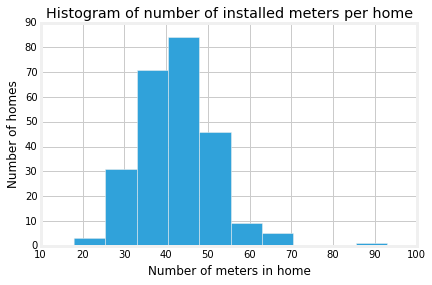

In [8]:
pd.Series(num_meters).hist();
plt.xlabel("Number of meters in home")
plt.ylabel("Number of homes");
plt.title("Histogram of number of installed meters per home");

A large number of homes have more than 30 meters! That's the most dense instrumentation at this scale that I'm aware of!

### Distribution of appliances across home

We'll now see how many appliance types are monitored across the data sets and which are the commonly occuring appliance types in the data set

In [9]:
categories = set()
appliance_types = set()
for appliance in nilmtk.global_meter_group.appliances:
    categories.update(appliance.categories())
    appliance_types.add(appliance.type['type'])

In [10]:
len(appliance_types)

70

Wow! We have 70 different appliance types in the data set. Here is a peek into few of these.

In [11]:
list(appliance_types)[:10]

['hair dryer',
 'RF booster',
 'shower pump',
 'sun bed',
 'scanner',
 'clothes iron',
 'electric blanket',
 'stove',
 'paper shredder',
 'breadmaker']

Let us now find out the number of instances of these appliances in each home.

In [12]:
out = {}
for building_num, building in ds.buildings.iteritems():
    out[building_num] = {}
    for appliance in list(appliance_types):
        try:
            elec = building.elec
            elec_appliance = elec.select_using_appliances(type=appliance)
            count = len(elec_appliance.meters)
        except:
            count=0
        out[building_num][appliance] = count


In [13]:
appliance_data_df = pd.DataFrame(out)

In [14]:
appliance_data_df.head()

,1,2,3,4,5,6,7,8,9,10,...,241,242,243,244,245,246,247,248,249,250
AV recorder,0,0,0,1,1,2,1,1,0,1,...,0,0,0,1,1,1,1,1,1,1
DVD player,3,1,0,1,1,2,2,0,1,0,...,2,1,1,1,1,1,1,2,1,1
ICT appliance,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RF booster,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USB hub,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us look at the mean count of an appliance across homes

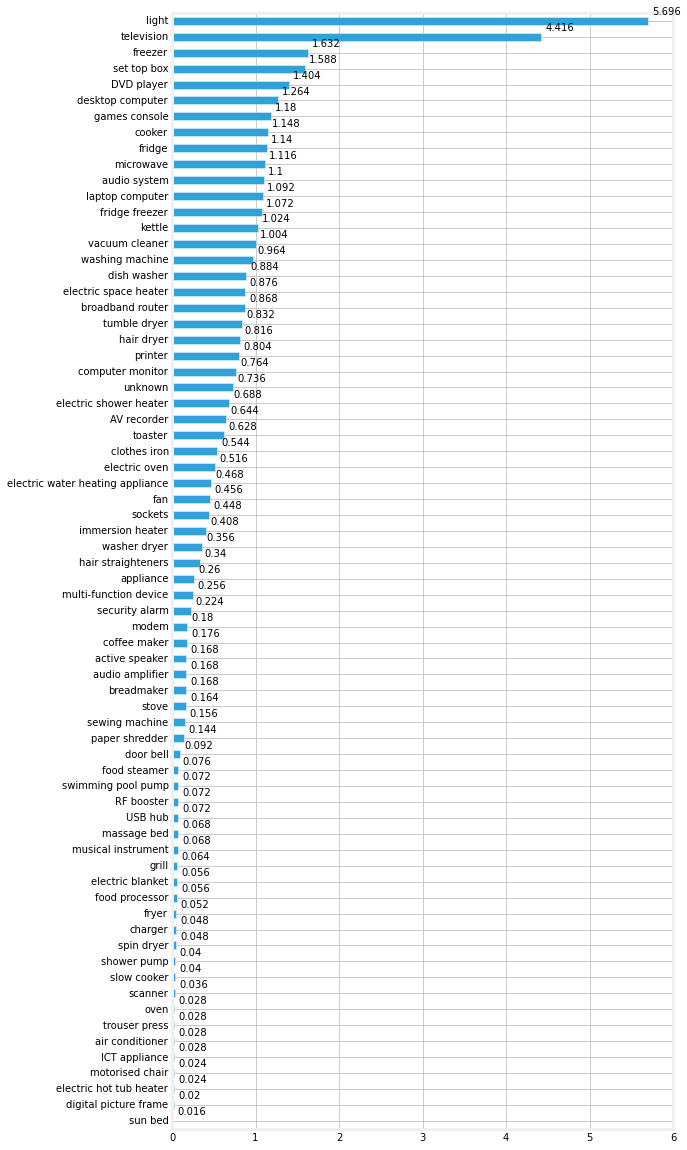

In [15]:
mean_appliance_home = pd.DataFrame(out).mean(axis=1)
mean_appliance_home.sort()
ax = mean_appliance_home.plot(kind="barh", figsize=(8,20))
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

Ok, 7 lights instrumented per home makes sense. But, what about the 4 televisions per home on an average! That sounds weird.

Let us now see the distribution of different appliances per home, instead of looking at the mean as we did in the plot above.

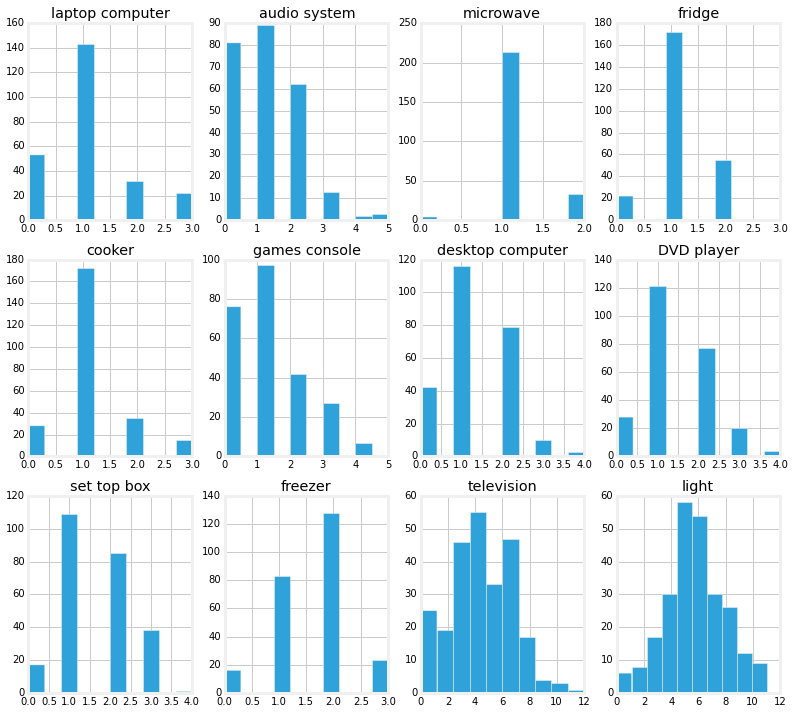

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12,12))
top_12_appliances = mean_appliance_home.tail(12).index
for i, appliance in enumerate(top_12_appliances):
    appliance_data_df.ix[appliance].hist(ax=ax[i/4, i%4])
    ax[i/4, i%4].set_title(appliance)    

### Duration of data collection across homes

We'll make the assumption that the first meter indicates whether or not data was collected during an interval in the home.

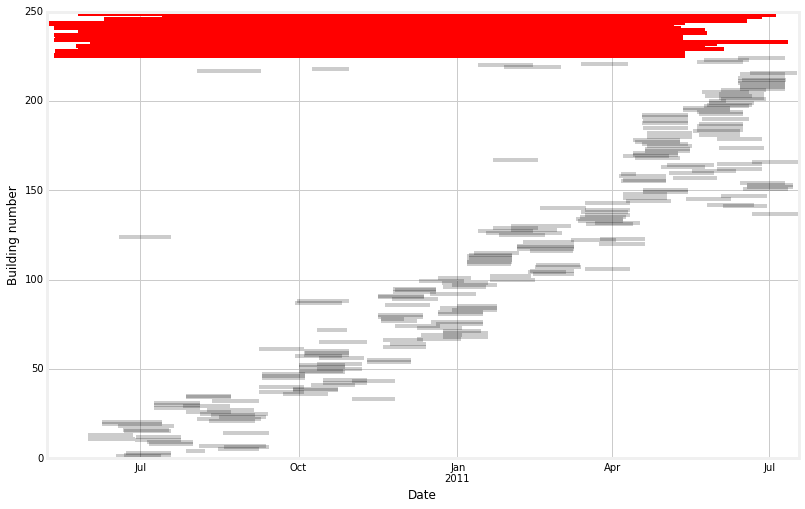

In [17]:
durations = {}
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
for building_num, building in ds.buildings.iteritems():
    elec = building.elec
    df = elec.meters[1].load().next().resample('1D')[('power','active')]
    duration = (df.index[-1]-df.index[0]).total_seconds()/(1440*60)
    durations[building_num] = duration
    df_home = pd.Series(building_num, index=df.index)
    if duration<150:
        df_home.plot(style='', alpha=0.2, color='k')
    else:
         df_home.plot(style='-', alpha=1, color='r')
    plt.ylabel("Building number")
    plt.xlabel("Date")

We can see that of the 250 homes, only a few have about an year long data collection. Let us look into this in more details.

In [18]:
durations_ser = pd.Series(durations)

In [19]:
durations_ser.describe()

count    250.0000
mean      59.5840
std      101.2492
min        0.0000
25%       26.0000
50%       26.0000
75%       27.0000
max      370.0000
dtype: float64

So, the maximum number of days for which instrumentation was carried is 370 days. Let us find the number of homes for which data collection was close to an year

In [20]:
over_year = durations_ser[durations_ser>335]

In [21]:
over_year.describe()

count     24.000000
mean     363.541667
std        3.671028
min      348.000000
25%      364.000000
50%      364.000000
75%      364.000000
max      370.000000
dtype: float64

So, we have 24 homes which have about an year of data. Let's find the nilmtk building id for these buildings.

In [22]:
over_year.index

Int64Index([225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
            238, 239, 240, 241, 243, 244, 245, 246, 247, 249, 250],
           dtype='int64')

So, nilmtk buildings with ids from 225 to 250 have about an year worth data.

### Weekly, Monthly trends on aggregate 

Now, for these 25 homes let us look at the aggregate energy consumption trends.

In [23]:
ts_dfs = {}
to_ignore_buildings = [234]
for building_num in over_year.index:
    if building_num not in to_ignore_buildings:
        elec = ds.buildings[building_num].elec
        ts_dfs[building_num] = elec.load().next()

Loading data for meter ElecMeterID(instance=41, building=225, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=31, building=226, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=34, building=227, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=37, building=228, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=29, building=229, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=34, building=230, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=41, building=231, dataset='HES')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=37, building=232, dataset='HES')     
Done loading data all meters 

### Day of week and hour of day trend

In [24]:
out_day = {}
out_hour = {}
out_month = {}

for building_num, building_df in ts_dfs.iteritems():
    building_df = building_df.resample("15T")
    building_df["day"] = building_df.index.dayofweek
    building_df["hour"] = building_df.index.hour
    building_df["month"] = building_df.index.month
    out_day[building_num] = building_df.groupby("day").mean()[("power","active")]
    out_hour[building_num] = building_df.groupby("hour").mean()[("power","active")]
    out_month[building_num] = building_df.groupby("month").mean()[("power","active")]

    

Let us now visualise mean power consumption across hour of day.

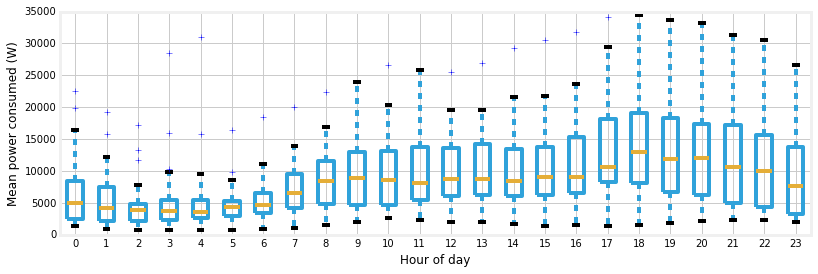

In [25]:
pd.DataFrame(out_hour).T.plot(kind="box", figsize=(12,4))
plt.xlabel("Hour of day")
plt.ylabel("Mean power consumed (W)");

As we might expect, there is lower mean power consumption in the night hours and then an increase after 5 PM (17 hours). Another way to visualise this information is from the plot below.

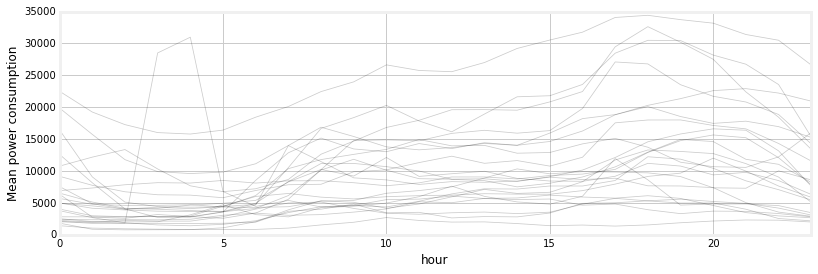

In [26]:
pd.DataFrame(out_hour).plot(legend=False, alpha=0.2, color='k', linewidth=0.8, figsize=(12,4))
plt.ylabel("Mean power consumption");

All the homes show pretty much similar pattern across the 24 hours.

Let us now visualise mean power consumption across day of week. We might expect to see some deviation across the 7 days.

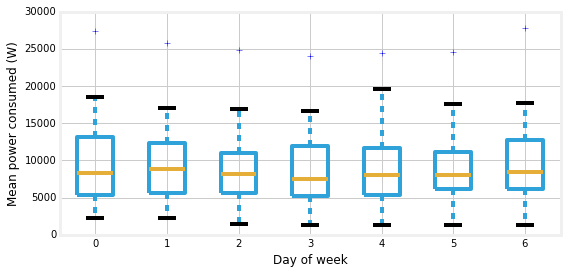

In [27]:
pd.DataFrame(out_day).T.plot(kind="box", figsize=(8,4))
plt.xlabel("Day of week")
plt.ylabel("Mean power consumed (W)");

It is hard to see deviation across the days of the week. Let us now look into an alternative visualisation by looking at the fraction of energy consumed by day of week.

In [28]:
fraction_day = pd.DataFrame(out_day).div(pd.DataFrame(out_day).sum())

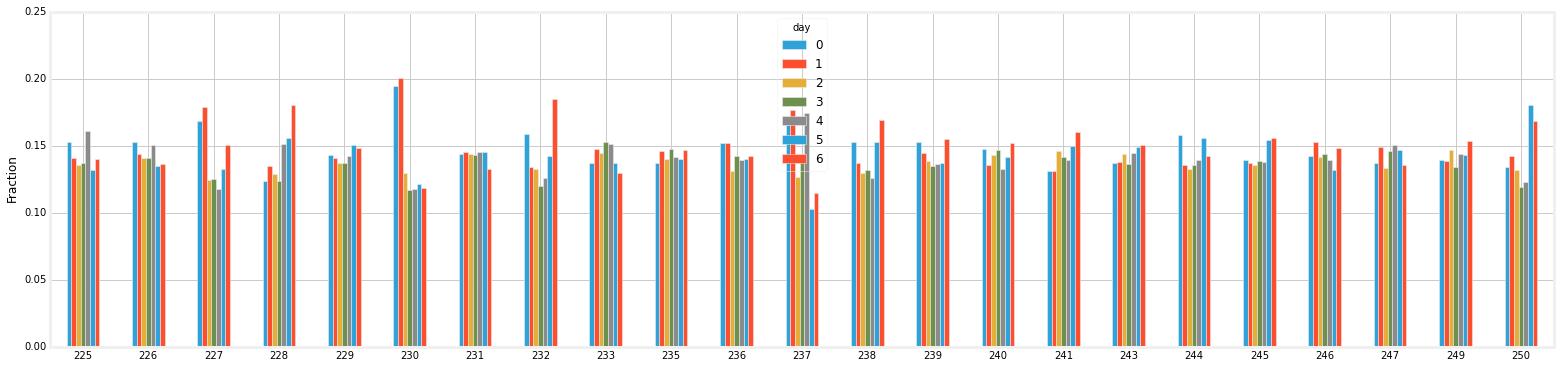

In [29]:
fraction_day.T.plot(kind='bar', figsize=(24, 6), rot=0)
plt.ylabel("Fraction")

For home #227, Monday and Tuesday have a very high usage as compared to other days. For home #250, weekends see higher energy consumption.

### Energy consumption trend by month

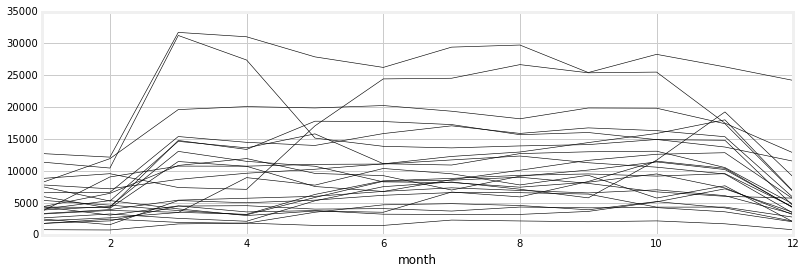

In [30]:
pd.DataFrame(out_month).plot(figsize=(12,4), legend=False, color='k',linewidth=0.6)

It is difficult to see any pattern here. Let us try an alternative visualisation where we scale the energy consumption across each home to be at max 1.

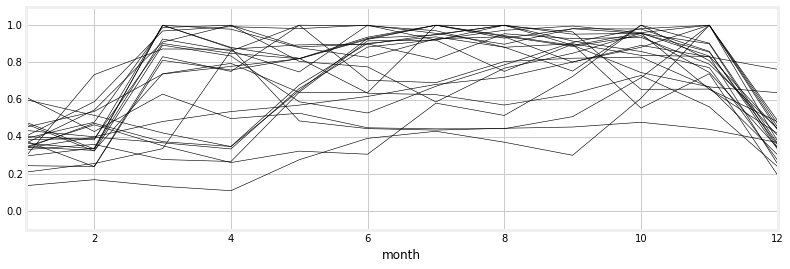

In [31]:
pd.DataFrame(out_month).div(pd.DataFrame(out_month).max()).plot(figsize=(12,4), legend=False, color='k',linewidth=0.6)
plt.ylim((-0.1,1.1));

Ok, so summer months seem to have a higher energy footprint than the winter months. Maybe, the heating is gas based?

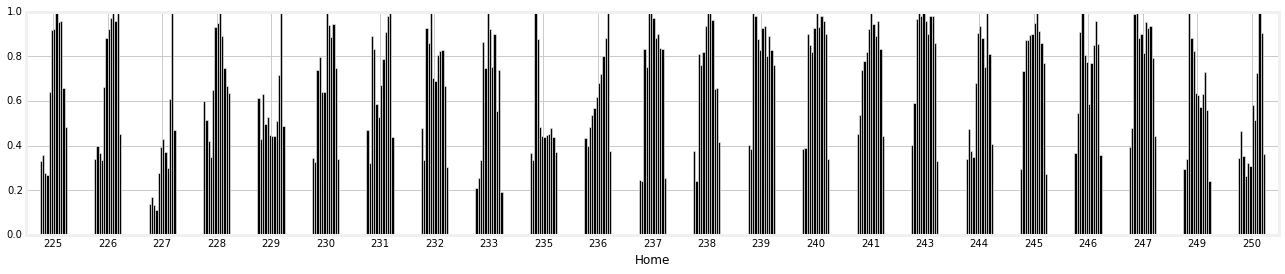

In [32]:
pd.DataFrame(out_month).div(pd.DataFrame(out_month).max()).T.plot(kind="bar",figsize=(20,4),rot=0, legend=False, color='k',linewidth=0.6)
plt.xlabel("Home");

The above visualisalisation is another way of looking at the distribution of energy across the months.

But, why do we even see such a trend. Let's do a quick exploratory research by looking at different appliances.

In [33]:
appliances_in_25_homes = pd.DataFrame(out)[range(225, 251)].sum(axis=1)
appliances_in_25_homes.sort(ascending=False)
appliances_in_25_homes.head(10)

light               128
television          105
freezer              69
audio system         45
desktop computer     36
set top box          29
DVD player           29
microwave            28
washing machine      26
cooker               26
dtype: int64

In [34]:
appliances_in_25_homes.ix['electric space heater']

12

So, only 12 of these homes seem to have electric space heating. Maybe that means that homes are typically heated using gas? 

In [35]:
space_heater_count = pd.DataFrame(out)[range(225, 251)].ix['electric space heater']
space_heater_count[space_heater_count>0]

225    1
227    1
228    2
229    2
233    2
239    2
246    1
248    1
Name: electric space heater, dtype: int64

So, actually, only 8 homes have electric space heating monitored. It also looks that even for these 8 homes the winter energy consumption is lower than the summer energy consumption. I'd leave the suspense open till I get a chance to write a follow up post on this data set. I hope it was fun reading the blog post and seeing that it is trivial to do a bunch of analysis in nilmtk.